In [127]:
import re
import pandas as pd
import numpy as np
from pathlib import Path
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_stopwords
from pythainlp.ulmfit import *
import matplotlib.font_manager

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

# params
pd.set_option("max_colwidth", 0)
sns.set_context("talk")
sns.set_palette(sns.color_palette("colorblind", 10))

matplotlib.rc("font", family="Arial Unicode MS")

%matplotlib inline

### Reading Data ###

In [128]:
# import dataset

train_data = pd.read_csv('newsHeadlineDataset.csv')
df = pd.DataFrame(train_data)
df

,category,texts
0,ham,สธ. เปิดตัวรถฟอกไตเคลื่อนที่นวัตกรรมต้นแบบคันแรกของไทย
1,ham,สธ.เพิ่มศักยภาพโรงพยาบาลธัญญารักษ์ภูมิภาครองรับผู้ป่วยจิตเวชทั่วประเทศ
2,spam,หุ้นเทรดยักษ์ใหญ่กำไรแน่นเริ่มต้นเทรดเพียง 1000 บาทรับปันผล 30000 ต่อเดือน
3,spam,"กรมการจัดหางาน เปิดโครงการ ""ไม่เลือกงาน ไม่ยากจน"" ให้คนไทยมีรายได้เสริม"
4,spam,"เพจ SAO Trading ในเครือของ AOT เปิดให้ลงทุนเริ่มต้น 1,000 บาท"
...,...,...
2565,spam,เพจเฟซบุ๊กของบริษัทตลาดหลักทรัพย์แห่งประเทศไทยแนะนำการลงทุน
2566,ham,"ครม.อนุมัติค่ารักษาพยาบาลจากเดิม50,000เพิ่มเป็น65,000บาท"
2567,spam,กดCancel2ครั้งก่อนสอดบัตรATMเพื่อป้องกันมิจฉาชีพ
2568,ham,นอนดึกตื่นเที่ยงในระยะยาวเสี่ยงอันตรายถึงชีวิต


In [129]:
df.describe()

,category,texts
count,2570,2570
unique,2,2570
top,ham,สธ. เปิดตัวรถฟอกไตเคลื่อนที่นวัตกรรมต้นแบบคันแรกของไทย
freq,1285,1


In [130]:
df[df.duplicated()]

,category,texts


In [131]:
df.groupby("category").describe()

texts         \
         count unique   
category                
ham       1285  1285    
spam      1285  1285    

                                                                                      \
                                                                                 top   
category                                                                               
ham       สธ. เปิดตัวรถฟอกไตเคลื่อนที่นวัตกรรมต้นแบบคันแรกของไทย                       
spam      หุ้นเทรดยักษ์ใหญ่กำไรแน่นเริ่มต้นเทรดเพียง 1000 บาทรับปันผล 30000 ต่อเดือน   

               
         freq  
category       
ham       1    
spam      1

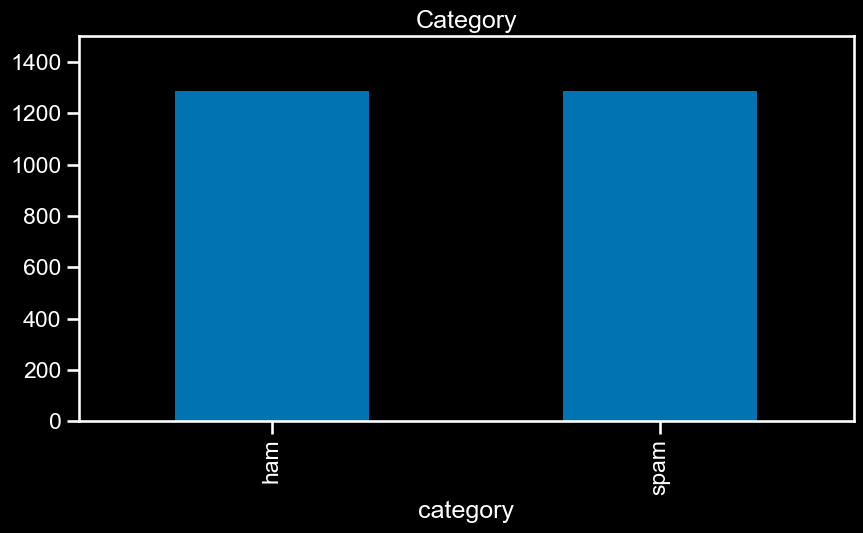

In [132]:
row_count_by_category = df.category.value_counts()
ax = row_count_by_category.plot(kind='bar', title="Category", figsize=(10, 5))
ax.set_ylim(0, 1500)
for i, label in enumerate(row_count_by_category):
    ax.annotate(str(label), (i-0.1, label + 500))

### Word Embedding ###

In [133]:
from pythainlp.tokenize import word_tokenize
from gensim.models import KeyedVectors
import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import dill as pickle
import pandas as pd

model_path = './'

In [134]:
from pythainlp import word_vector
model = word_vector.WordVector(model_name="thai2fit_wv").get_model() # load thai2fit_wv from pythainlp

In [135]:
thai2dict = {}
for word in model.index_to_key:
    thai2dict[word] = model[word]
thai2vec = pd.DataFrame.from_dict(thai2dict,orient='index')
thai2vec.head(10)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
ที่,0.308956,-0.097699,0.116745,0.215612,0.015768,-0.064163,0.062168,0.039649,0.864940,0.846904,...,-0.142418,0.033241,0.171581,-0.624864,-0.009358,0.449131,0.120130,-0.122195,-0.450617,-0.071318
และ,0.010751,-0.618971,0.129665,0.035460,-0.007560,0.027607,0.397824,0.026543,0.254075,0.168328,...,-0.105786,0.180930,-0.101630,0.070885,-0.037263,0.183606,-0.049088,-0.672288,-1.293044,0.592576
เป็น,-0.015736,-0.258926,0.052953,0.153728,-0.005985,-0.021081,0.041088,0.057312,1.633230,0.442729,...,-0.009408,-0.252576,-0.305512,0.372542,0.049151,0.568470,0.266586,0.400800,-0.784650,0.197369
ของ,-0.189711,-0.174774,0.171124,-0.186771,0.054294,-0.114150,-1.109456,-0.094466,-0.447015,0.042377,...,-0.168676,-0.148738,0.680404,0.097702,0.020270,0.182967,-0.083949,0.006287,-0.707434,-0.070234
มี,-0.156962,-0.231863,0.080312,0.323157,0.215695,0.055145,0.420794,0.016842,0.256759,0.832864,...,-0.044267,-0.147186,-0.105424,0.907078,0.009299,0.550953,0.139337,0.031696,-0.670379,-0.008048
ได้,-0.428813,-0.031194,0.041922,-0.036608,-0.008106,0.076470,-0.782270,0.033361,0.606864,0.440520,...,0.024458,-0.025031,0.103389,-0.078255,0.034323,0.459774,-0.748643,0.337775,-0.487408,-0.511535
"""""""""",-0.287710,0.064193,0.205076,0.146356,-0.071343,-0.039451,-1.845461,0.163763,1.018096,0.272786,...,0.051024,-0.532856,-0.131856,-0.090323,-0.058895,0.151262,-0.420358,0.055971,-0.930814,0.163908
การ,0.239587,-0.303620,0.079953,-0.453045,-0.528826,-0.161692,0.235725,-0.099673,0.691668,0.536159,...,-0.110436,-0.297495,-0.217414,0.045158,0.066647,0.190095,-0.304333,-0.724927,-0.995488,-0.716609
(,-0.120522,-0.355783,0.168180,-0.377733,-0.158624,-0.047249,0.361140,0.161460,0.913314,0.345037,...,0.116285,-0.318218,-0.356664,0.519889,0.130475,0.125772,0.101328,-0.382658,-1.205359,0.340139
),-0.086848,-0.155231,0.133015,-0.039913,0.183761,0.115142,-1.940854,-0.066565,-2.399744,0.146722,...,0.019406,-0.181474,0.099863,0.516092,0.201697,0.249139,0.252957,1.138815,-0.018209,0.232265


In [ ]:
# !wget https://github.com/PyThaiNLP/tutorials/releases/download/thai2plot/thai2plot.pkl

In [136]:
labels = model.index_to_key

thai2plot = pickle.load(open(f'{model_path}thai2plot.pkl','rb'))

In [137]:
labels[:10]

['ที่', 'และ', 'เป็น', 'ของ', 'มี', 'ได้', '""""', 'การ', '(', ')']

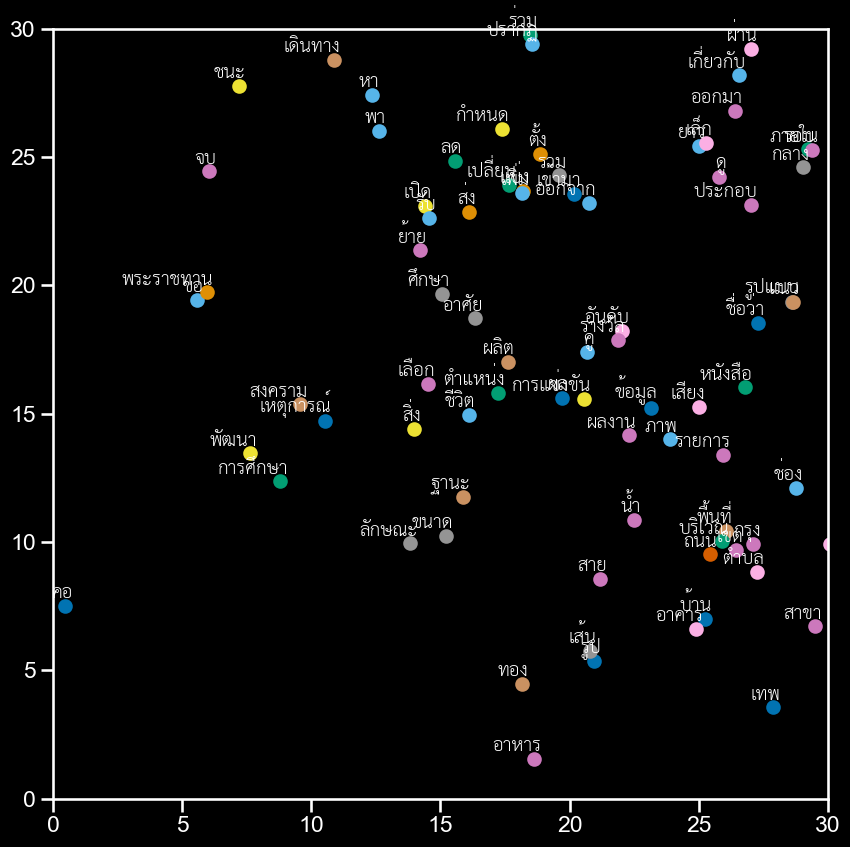

In [138]:
def plot_with_labels(low_dim_embs, labels, filename=None, figsize=(10,10),
                    axis_lims = None):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=figsize)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        prop = fm.FontProperties(fname=f'TH-Sarabun-New-Regular.ttf',size=20)
        plt.annotate(label,
                 fontproperties=prop,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    if axis_lims is not None: plt.axis(axis_lims)
    if filename: plt.savefig(filename)

plot_with_labels(thai2plot[200:500],labels[200:500],axis_lims = [0,30,0,30])

def get_word_embeddings(tokens):
    embeddings = [model[word] for word in tokens if word in model]
    return embeddings

def aggregate_embeddings(embeddings):
    if embeddings:
        return sum(embeddings) / len(embeddings)
    else:
        return None

### Train-Test Split ###

In [139]:
from sklearn.model_selection import train_test_split

# Assuming X_train contains your training text data

class_names = np.unique(df.category).tolist()

X = df['texts']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

X_train_embeddings = []
X_test_embeddings = []

for document in X_train:
    tokens = word_tokenize(document)
    embeddings = get_word_embeddings(tokens)
    document_embedding = aggregate_embeddings(embeddings)
    X_train_embeddings.append(document_embedding)
    
    
for document in X_test:
    tokens = word_tokenize(document)
    embeddings = get_word_embeddings(tokens)
    document_embedding = aggregate_embeddings(embeddings)
    X_test_embeddings.append(document_embedding)

In [140]:
mapping = {"ham": 0, "spam": 1}
y_train = [mapping[label] for label in y_train]
y_test = [mapping[label] for label in y_test]
# y_train

### *XGBoost Random Forest* ###

In [141]:
import xgboost
from xgboost import XGBRFClassifier
from sklearn.pipeline import make_pipeline


XGBRF_clf = make_pipeline(
    # subsample nad closamples must be less than 1 to enable random selection!
    XGBRFClassifier(
        n_estimators=83, subsample=0.9, colsample_bynode=0.2, max_depth=10, learning_rate=0.0001, gamma=1e-02,
        random_state=42, eval_metric=['auc', 'logloss'], objective='binary:logistic', n_jobs=-1
    )
)

%time XGBRF_clf.fit(X_train_embeddings, y_train)

XGBRF_clf.predict(X_test_embeddings)
XGBRF_clf.score(X_test_embeddings, y_test)

CPU times: user 17.8 s, sys: 2.8 s, total: 20.6 s
Wall time: 3.01 s


0.8132295719844358

In [142]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_auc_score

print()
print("Training:\n")

ypred_test = XGBRF_clf.predict(X_test_embeddings)
mat_clf = confusion_matrix(y_test, ypred_test)
report_clf = classification_report(y_test, ypred_test)

# Confusion matrix
clf_matrix = metrics.confusion_matrix(y_test, ypred_test)

print(mat_clf)
print(report_clf)

y_pred_proba = XGBRF_clf.predict_proba(X_test_embeddings)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)

print("AUC score: ", auc)


Training:

[[215  42]
 [ 54 203]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       257
           1       0.83      0.79      0.81       257

    accuracy                           0.81       514
   macro avg       0.81      0.81      0.81       514
weighted avg       0.81      0.81      0.81       514

AUC score:  0.8899074929219217


In [143]:
y_test_rep = y_test
ypred_test_rep = ypred_test

In [144]:
from sklearn.metrics import f1_score

print("F1-score: ", f1_score(y_test_rep, ypred_test_rep))

F1-score:  0.8087649402390438


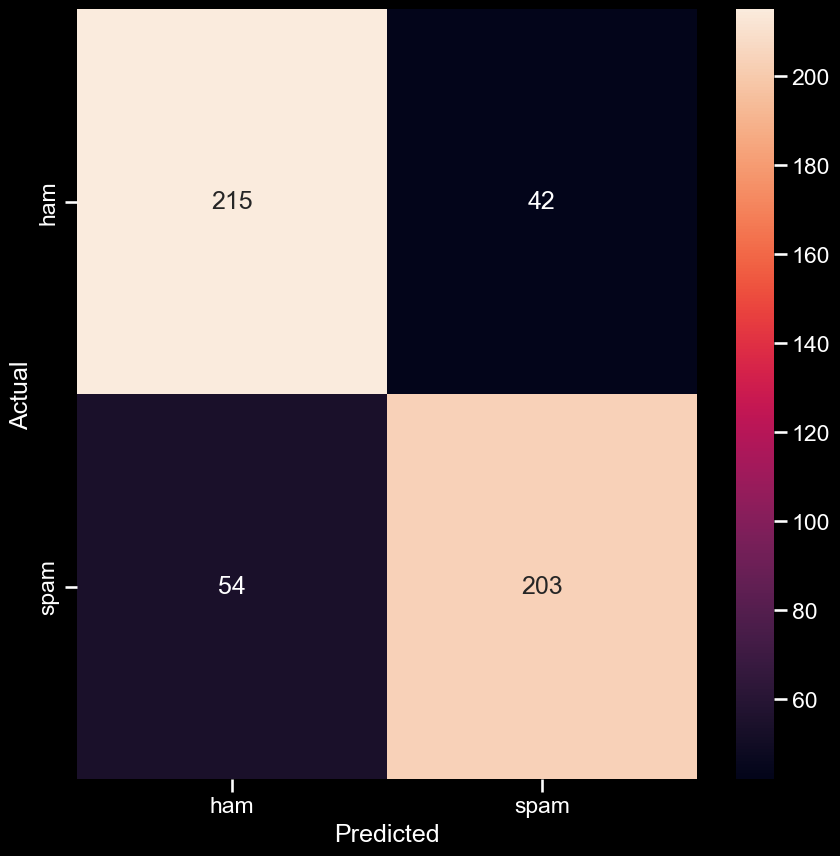

In [145]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, XGBRF_clf.predict(X_test_embeddings))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [146]:
from collections import Counter

predict_msg = ["รองต่อ รุดที่เกิดเหตุหลัง ผกก.ทล. เครียดกรณี สว.แบงค์ ก่อนยิงตัวตาย",
               "วงจรปิดชัด หน่อง ท่าผา ขับรถมาคันเดียว เลี้ยวเข้าซอยก่อนโดนวิสามัญ",
               "ผกก.สน.พญาไท โดนหางเลข ร่วมงานเลี้ยงบ้าน กำนันนก น.1 สั่งตั้ง กก.สอบ",
               "อนุทิน ชมฝ่ายค้านมีสปิริตอภิปราย ไม่ไล่บี้รัฐบาล ยังอุบชื่อรองโฆษกฯ",
               "นายกฯ เตือน โตๆ กันแล้ว จ่อคุยเยอรมนี ปมเครื่องยนต์เรือดำน้ำ “โรม” ประท้วงเสียดสี",
               "ตลาดหลักทรัพย์ฯร่วมกับบริษัทมหาชนที่ดำเนินธุรกิจด้านการลงทุนและพัฒนาอสังหาริมทรัพย์เปิดให้ซื้อกองทุนวัยเกษียณ10,000บาทปันผล10-12%",
               "ลงทุนในสินทรัพย์Top10ของโลกเริ่มต้น1,000บาทภายใต้การควบคุมของตลาดหลักทรัพย์แห่งประเทศไทย",
               "ชวนลงทุนกองทุนทองคำคุณภาพเริ่มพอร์ต1,000บาทเปิดพอร์ตวันนี้รับทองคำน้ำหนัก2.5กรัม",
               "เพจเฟซบุ๊กเปิดขายSET50กองทุนรวมทองคำไทยราคาเปิดพอร์ต999บาทและ3999บาทความเสี่ยงต่ำลงทุนครั้งเดียวปันผลไม่หมดอายุ",
               "วิธีรักษามะเร็งให้หายได้ไม่ให้ทำคีโมแต่ให้กำหนดลมหายใจตัวเองและกินอาหารที่ไม่เป็นกรด"               
               ]

# Defining prediction function
def predict_spam(predict_msg_embeddings):
    
    predict_msg_embeddings = []
    
    for document in predict_msg:
            tokens = word_tokenize(document)
            embeddings = get_word_embeddings(tokens)
            document_embedding = aggregate_embeddings(embeddings)
            predict_msg_embeddings.append(document_embedding)
    return (XGBRF_clf.predict(predict_msg_embeddings))

predict_spam(predict_msg)

summary = predict_spam(predict_msg)
mapping = {0:"ham", 1:"spam"}
summary = [mapping[label] for label in summary]
count = Counter(summary)
print("Output:", summary, " => ", count)

Output: ['ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam']  =>  Counter({'spam': 6, 'ham': 4})


### ROC-AUC graph ###

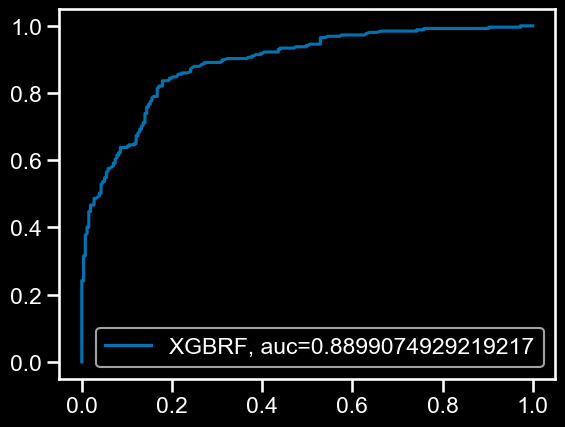

In [147]:
y_pred_proba = XGBRF_clf.predict_proba(X_test_embeddings)[::,1]
# y_test = y_test.map({'spam': 1, 'ham': 0}).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr, label="XGBRF, auc="+str(auc))

plt.legend(loc=4)
plt.show()

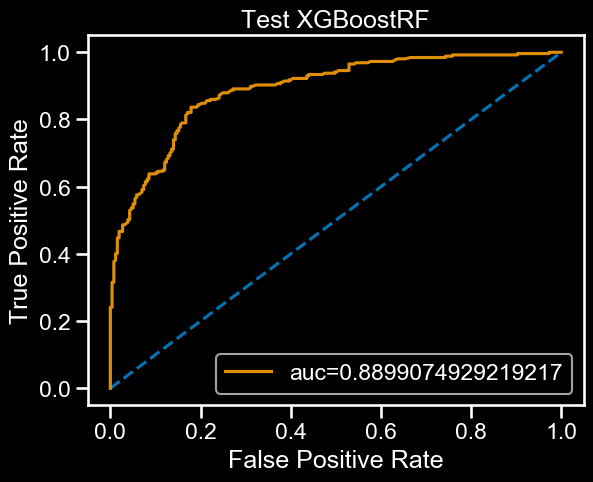

In [148]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(y_test))]
lr_probs = XGBRF_clf.predict_proba(X_test_embeddings)[::,1]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.title("Test XGBoostRF")
pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
pyplot.plot(lr_fpr, lr_tpr,label="auc="+str(auc))

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

### Pickle model ###

In [149]:
import pickle

XGBRF_clf = make_pipeline(
    XGBRFClassifier(n_estimators=26, subsample=0.9, colsample_bynode=0.2, max_depth=10, random_state=42)
)

%time XGBRF_clf.fit(X_train_embeddings, y_train)

with open('pkl/XGBRF_Embedding.pkl', 'wb') as file:
    pickle.dump(XGBRF_clf, file)

CPU times: user 5.92 s, sys: 2.03 s, total: 7.95 s
Wall time: 1.3 s
